In [1]:
import pandas as pd
import numpy as np

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [3]:
exch = 'BTRX'
pair = 'BTC/USDT'

df = pd.read_csv(f"{exch}_{pair.replace('/', '-')}_ohlcv.csv")
df.head()

,timestamp,open,high,low,close,volume
0,2016-12-31 05:02:00,948.000,948.000,942.899,942.899,0.083403
1,2016-12-31 05:03:00,942.899,942.899,942.899,942.899,0.000000
2,2016-12-31 05:04:00,942.899,942.899,942.899,942.899,0.000000
3,2016-12-31 05:05:00,942.899,942.899,942.899,942.899,0.000000
4,2016-12-31 05:06:00,942.899,942.899,942.899,942.899,0.000000


In [4]:
df.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


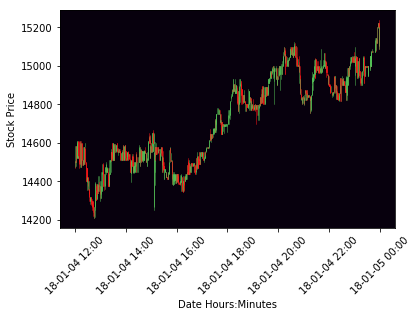

In [5]:
# Plot the stock prices for the last day
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

plot_last_n_minutes = 60 * 12  # 1/2 day
cs_frame = df.iloc[-1 * plot_last_n_minutes:].copy()  # Create the candlestick frame

#if necessary convert to datetime
cs_frame.timestamp = pd.to_datetime(cs_frame.timestamp)

cs_frame = cs_frame[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
cs_frame["timestamp"] = cs_frame["timestamp"].apply(mdates.date2num)

f1 = plt.subplot2grid((6, 1), (0, 0), rowspan=6, colspan=1, axisbg='#07000d')
candlestick_ohlc(f1, cs_frame.values, width=.0001, colorup='#53c156', colordown='#ff1717', alpha=.75)
f1.xaxis_date()
f1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.xlabel('Date Hours:Minutes')
plt.show()

# Cleanup memory
%reset_selective -f "^cs_frame$"

In [6]:
# Add a minute moving average over period
def add_moving_avg(df, period=30):
    df[f"{period}_ma"] = pd.rolling_mean(df['close'], period)

In [7]:
add_moving_avg(df)
df.tail()

/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


,timestamp,open,high,low,close,volume,30_ma
532493,2018-01-04 23:55:00,15199.000000,15200.00000,15199.000000,15199.000000,10.446506,15063.411186
532494,2018-01-04 23:56:00,15199.000000,15220.00000,15195.582639,15220.000000,5.457758,15070.777853
532495,2018-01-04 23:57:00,15220.000000,15238.00000,15200.000000,15201.000000,7.473745,15077.644520
532496,2018-01-04 23:58:00,15200.000000,15202.21529,15085.001000,15101.591266,7.258691,15081.030929
532497,2018-01-04 23:59:00,15101.591266,15199.00000,15085.001000,15199.000000,1.777752,15087.697595


In [8]:
from stock_gym.envs import stocks
import gym

env = gym.make('FakeMarketEnv-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

In [10]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [11]:
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
(nb_actions, env.observation_space.shape)

(3, (1, 64))

In [12]:
model = Sequential()
model.add(Flatten(input_shape=env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions, activation='linear'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

In [13]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()

In [14]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               enable_dueling_network=True, dueling_type='avg', target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [15]:
dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)

Training for 50000 steps ...


/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


   129/50000: episode: 1, duration: 1.357s, episode steps: 129, steps per second: 95, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.116 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000000, mean_absolute_error: 0.001086, mean_q: 0.001679
   258/50000: episode: 2, duration: 0.598s, episode steps: 129, steps per second: 216, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.062 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000000, mean_absolute_error: 0.001942, mean_q: 0.002946
   387/50000: episode: 3, duration: 0.601s, episode steps: 129, steps per second: 215, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.070 [0.000, 2.000], mean observation: 0.030 [0.013, 0.050], loss: 0.000001, mean_absolute_error: 0.002765, mean_q: 0.004331
   516/50000: episode: 4, duration: 0.659s, episode steps: 129, steps per second: 196, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean

  3870/50000: episode: 30, duration: 0.660s, episode steps: 129, steps per second: 195, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.876 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000003, mean_absolute_error: 0.018545, mean_q: 0.028007
  3999/50000: episode: 31, duration: 0.640s, episode steps: 129, steps per second: 202, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.922 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000003, mean_absolute_error: 0.018926, mean_q: 0.028565
  4128/50000: episode: 32, duration: 0.655s, episode steps: 129, steps per second: 197, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.977 [0.000, 2.000], mean observation: 0.017 [0.012, 0.026], loss: 0.000003, mean_absolute_error: 0.019405, mean_q: 0.029191
  4257/50000: episode: 33, duration: 0.602s, episode steps: 129, steps per second: 214, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001],

  7611/50000: episode: 59, duration: 0.783s, episode steps: 129, steps per second: 165, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.031 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000009, mean_absolute_error: 0.028660, mean_q: 0.043117
  7740/50000: episode: 60, duration: 1.148s, episode steps: 129, steps per second: 112, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.054 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000009, mean_absolute_error: 0.028737, mean_q: 0.043178
  7869/50000: episode: 61, duration: 0.570s, episode steps: 129, steps per second: 226, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.876 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000006, mean_absolute_error: 0.028932, mean_q: 0.043593
  7998/50000: episode: 62, duration: 0.890s, episode steps: 129, steps per second: 145, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001],

 11352/50000: episode: 88, duration: 0.856s, episode steps: 129, steps per second: 151, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.023 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000009, mean_absolute_error: 0.033775, mean_q: 0.050845
 11481/50000: episode: 89, duration: 0.855s, episode steps: 129, steps per second: 151, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.922 [0.000, 2.000], mean observation: 0.027 [0.017, 0.042], loss: 0.000011, mean_absolute_error: 0.033849, mean_q: 0.050920
 11610/50000: episode: 90, duration: 0.836s, episode steps: 129, steps per second: 154, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.938 [0.000, 2.000], mean observation: 0.104 [0.067, 0.162], loss: 0.000009, mean_absolute_error: 0.033970, mean_q: 0.051058
 11739/50000: episode: 91, duration: 0.828s, episode steps: 129, steps per second: 156, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001],

 15093/50000: episode: 117, duration: 0.848s, episode steps: 129, steps per second: 152, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.031 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000012, mean_absolute_error: 0.036201, mean_q: 0.054457
 15222/50000: episode: 118, duration: 0.817s, episode steps: 129, steps per second: 158, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.969 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000010, mean_absolute_error: 0.036196, mean_q: 0.054313
 15351/50000: episode: 119, duration: 0.829s, episode steps: 129, steps per second: 156, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.884 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000013, mean_absolute_error: 0.036389, mean_q: 0.054520
 15480/50000: episode: 120, duration: 0.889s, episode steps: 129, steps per second: 145, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

 18834/50000: episode: 146, duration: 0.875s, episode steps: 129, steps per second: 147, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.124 [0.000, 2.000], mean observation: 0.026 [0.020, 0.037], loss: 0.000010, mean_absolute_error: 0.037374, mean_q: 0.056076
 18963/50000: episode: 147, duration: 0.822s, episode steps: 129, steps per second: 157, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.953 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000011, mean_absolute_error: 0.037704, mean_q: 0.056689
 19092/50000: episode: 148, duration: 0.799s, episode steps: 129, steps per second: 161, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.953 [0.000, 2.000], mean observation: 0.001 [0.000, 0.002], loss: 0.000010, mean_absolute_error: 0.037631, mean_q: 0.056677
 19221/50000: episode: 149, duration: 0.824s, episode steps: 129, steps per second: 157, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

 22575/50000: episode: 175, duration: 0.675s, episode steps: 129, steps per second: 191, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.899 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000018, mean_absolute_error: 0.038561, mean_q: 0.057934
 22704/50000: episode: 176, duration: 0.667s, episode steps: 129, steps per second: 193, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.085 [0.000, 2.000], mean observation: 0.031 [0.017, 0.046], loss: 0.000012, mean_absolute_error: 0.038504, mean_q: 0.057918
 22833/50000: episode: 177, duration: 0.650s, episode steps: 129, steps per second: 198, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.969 [0.000, 2.000], mean observation: 0.003 [0.001, 0.004], loss: 0.000014, mean_absolute_error: 0.038562, mean_q: 0.057805
 22962/50000: episode: 178, duration: 0.648s, episode steps: 129, steps per second: 199, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

 26316/50000: episode: 204, duration: 0.663s, episode steps: 129, steps per second: 195, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.961 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000016, mean_absolute_error: 0.038800, mean_q: 0.058355
 26445/50000: episode: 205, duration: 0.616s, episode steps: 129, steps per second: 209, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.953 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000010, mean_absolute_error: 0.038919, mean_q: 0.058575
 26574/50000: episode: 206, duration: 0.567s, episode steps: 129, steps per second: 228, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.008 [0.000, 2.000], mean observation: 0.002 [0.001, 0.003], loss: 0.000015, mean_absolute_error: 0.038912, mean_q: 0.058397
 26703/50000: episode: 207, duration: 0.697s, episode steps: 129, steps per second: 185, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

 30057/50000: episode: 233, duration: 0.624s, episode steps: 129, steps per second: 207, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.078 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000011, mean_absolute_error: 0.038651, mean_q: 0.057985
 30186/50000: episode: 234, duration: 0.622s, episode steps: 129, steps per second: 207, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.984 [0.000, 2.000], mean observation: 0.443 [0.261, 0.734], loss: 0.000014, mean_absolute_error: 0.038648, mean_q: 0.058068
 30315/50000: episode: 235, duration: 0.642s, episode steps: 129, steps per second: 201, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.984 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000009, mean_absolute_error: 0.038711, mean_q: 0.058191
 30444/50000: episode: 236, duration: 0.698s, episode steps: 129, steps per second: 185, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

 33798/50000: episode: 262, duration: 0.920s, episode steps: 129, steps per second: 140, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.891 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000010, mean_absolute_error: 0.038623, mean_q: 0.058192
 33927/50000: episode: 263, duration: 0.679s, episode steps: 129, steps per second: 190, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.062 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000012, mean_absolute_error: 0.038486, mean_q: 0.057811
 34056/50000: episode: 264, duration: 0.772s, episode steps: 129, steps per second: 167, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.093 [0.000, 2.000], mean observation: 0.021 [0.010, 0.035], loss: 0.000013, mean_absolute_error: 0.038604, mean_q: 0.058059
 34185/50000: episode: 265, duration: 0.707s, episode steps: 129, steps per second: 182, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

 37539/50000: episode: 291, duration: 0.723s, episode steps: 129, steps per second: 178, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.977 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000014, mean_absolute_error: 0.038413, mean_q: 0.057637
 37668/50000: episode: 292, duration: 0.662s, episode steps: 129, steps per second: 195, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.953 [0.000, 2.000], mean observation: 0.051 [0.027, 0.102], loss: 0.000011, mean_absolute_error: 0.038654, mean_q: 0.058072
 37797/50000: episode: 293, duration: 0.662s, episode steps: 129, steps per second: 195, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.915 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000012, mean_absolute_error: 0.038340, mean_q: 0.057577
 37926/50000: episode: 294, duration: 0.667s, episode steps: 129, steps per second: 193, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

 41280/50000: episode: 320, duration: 0.703s, episode steps: 129, steps per second: 183, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.116 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000017, mean_absolute_error: 0.038222, mean_q: 0.057427
 41409/50000: episode: 321, duration: 0.593s, episode steps: 129, steps per second: 218, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.109 [0.000, 2.000], mean observation: 0.813 [0.471, 1.240], loss: 0.000012, mean_absolute_error: 0.038312, mean_q: 0.057654
 41538/50000: episode: 322, duration: 0.702s, episode steps: 129, steps per second: 184, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.047 [0.000, 2.000], mean observation: 0.069 [0.049, 0.115], loss: 0.000013, mean_absolute_error: 0.038707, mean_q: 0.058124
 41667/50000: episode: 323, duration: 0.734s, episode steps: 129, steps per second: 176, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

 45021/50000: episode: 349, duration: 0.596s, episode steps: 129, steps per second: 216, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 1.116 [0.000, 2.000], mean observation: 0.003 [0.001, 0.007], loss: 0.000014, mean_absolute_error: 0.038753, mean_q: 0.058204
 45150/50000: episode: 350, duration: 0.660s, episode steps: 129, steps per second: 196, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.884 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000012, mean_absolute_error: 0.038854, mean_q: 0.058454
 45279/50000: episode: 351, duration: 0.643s, episode steps: 129, steps per second: 201, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.961 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000016, mean_absolute_error: 0.038889, mean_q: 0.058365
 45408/50000: episode: 352, duration: 0.612s, episode steps: 129, steps per second: 211, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

 48762/50000: episode: 378, duration: 0.693s, episode steps: 129, steps per second: 186, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.992 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000017, mean_absolute_error: 0.039367, mean_q: 0.059204
 48891/50000: episode: 379, duration: 0.767s, episode steps: 129, steps per second: 168, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.938 [0.000, 2.000], mean observation: 0.000 [0.000, 0.000], loss: 0.000013, mean_absolute_error: 0.039384, mean_q: 0.059326
 49020/50000: episode: 380, duration: 0.710s, episode steps: 129, steps per second: 182, episode reward: 0.129, mean reward: 0.001 [0.001, 0.001], mean action: 0.930 [0.000, 2.000], mean observation: 0.017 [0.009, 0.022], loss: 0.000015, mean_absolute_error: 0.039309, mean_q: 0.059006
 49149/50000: episode: 381, duration: 0.646s, episode steps: 129, steps per second: 200, episode reward: 0.129, mean reward: 0.001 [0.001, 0.0

In [16]:
# After training is done, we save the final weights.
dqn.save_weights('duel_dqn_{}_weights.h5f'.format('stock_bot'), overwrite=True)

In [17]:
dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 0.129, steps: 129
Episode 2: reward: 0.129, steps: 129
Episode 3: reward: 0.129, steps: 129
Episode 4: reward: 0.129, steps: 129
Episode 5: reward: 0.129, steps: 129
